# Capstone Project
## Image Classification of Dog Breeds

#### Problem Statement: 
Using images of Boston Bulls, Beagles, and Boxers from ImageNet, predict breed of dog in the image.

*Import Necessary Libraries*

In [5]:
from os import listdir
from keras.utils import np_utils
from imutils import paths

import keras as ks
from keras import backend as K
import cv2
import numpy as np

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from skimage import restoration


Using TensorFlow backend.


## Part 1: Get Images from ImageNet

I found an amazing [repo](https://github.com/tzutalin/ImageNet_Utils) with CLI commands to download images and crop using the provided bounding boxes from ImageNet.

In [ ]:
%%bash
git clone --recursive https://github.com/tzutalin/ImageNet_Utils.git
cd ImageNet_Utils

# Download images of the three breeds using their synset ID
# Boston: n02096585
# Beagle: n02088364
# Boxer:  n02108089

./downloadutils.py --downloadOriginalImages --wnid n02096585
./downloadutils.py --downloadOriginalImages --wnid n02088364
./downloadutils.py --downloadOriginalImages --wnid n02108089


# Download Bounding Boxes

./downloadutils.py --downloadBoundingBox --wnid n02096585
./downloadutils.py --downloadBoundingBox --wnid n02088364
./downloadutils.py --downloadBoundingBox --wnid n02108089


# Crop Images by Bounding Box XML

./bbox_helper.py --save_boundingbox --bxmldir n02096585/
./bbox_helper.py --save_boundingbox --bxmldir n02088364/
./bbox_helper.py --save_boundingbox --bxmldir n02108089/


# Create Train, Test subfolders for each breed

mkdir data/{train/{n02096585,n02088364,n02108089},test/{n02096585,n02088364,n02108089}}

In [ ]:
# Determine the number of images to create a test set 
# consisting of 30% of each breed


test_n02096585 = len(listdir('data/n02096585_bounding_box_imgs'))*.3
test_n02088364 = len(listdir('data/n02088364_bounding_box_imgs'))*.3
test_n02108089 = len(listdir('data/n02108089_bounding_box_imgs'))*.3

print(test_n02096585,test_n02088364,test_n02108089)
#93, 118, 286

In [ ]:
%%bash

# Randomly select 30% of each breed's images and move to test folder

shuf -zen93 data/n02088364_bounding_box_imgs/*  | xargs -0 mv -t data/test/n02088364
shuf -zen118 data/n02096585_bounding_box_imgs/*  | xargs -0 mv -t data/test/n02096585
shuf -zen286 data/n02108089_bounding_box_imgs/*  | xargs -0 mv -t data/test/n02108089


# Use remaining 70% as train folder

mv data/n02088364_bounding_box_imgs data/train/n02088364
mv data/n02096585_bounding_box_imgs data/train/n02096585
mv data/n02108089_bounding_box_imgs data/train/n02108089

## Part 2: Image Augmentation

Import images

In [124]:
# grab the list of images that we'll be describing
print("[INFO] describing images...")


## train ##
imagePaths = list(paths.list_images("data/train"))

# initialize the data matrix and labels list
trainData = []
trainLabels = []

# loop over the input images
for (i, imagePath) in enumerate(imagePaths):
    # load the image and extract the class label (assuming that our
    # path as the format: /path/to/dataset/{class}.{image_num}.jpg
    image = cv2.imread(imagePath)
    label = imagePath.split(os.path.sep)[-1].split(".")[0]

    # construct a feature vector raw pixel intensities, then update
    # the data matrix and labels list
    image = cv2.resize(image, (28,28))
    trainData.append(image)
    trainLabels.append(label)

    # show an update every 200 images
    if i > 0 and i % 200 == 0:
        print("[INFO] processed {}/{}".format(i, len(imagePaths)))
        
print("[INFO] image processing complete")


## test ##
imagePaths = list(paths.list_images("data/test"))

# initialize the data matrix and labels list
testData = []
testLabels = []

# loop over the input images
for (i, imagePath) in enumerate(imagePaths):
    # load the image and extract the class label (assuming that our
    # path as the format: /path/to/dataset/{class}.{image_num}.jpg
    image = cv2.imread(imagePath)
    label = imagePath.split(os.path.sep)[-1].split(".")[0]

    # construct a feature vector raw pixel intensities, then update
    # the data matrix and labels list
    image = cv2.resize(image, (28,28))
    testData.append(image)
    testLabels.append(label)

    # show an update every 200 images
    if i > 0 and i % 200 == 0:
        print("[INFO] processed {}/{}".format(i, len(imagePaths)))
        
print("[INFO] image processing complete")

[INFO] describing images...
[INFO] processed 200/1164
[INFO] processed 400/1164
[INFO] processed 600/1164
[INFO] processed 800/1164
[INFO] processed 1000/1164
[INFO] image processing complete
[INFO] processed 200/497
[INFO] processed 400/497
[INFO] image processing complete


In [125]:
#take out unique file identifers so that theyre all set to synset id
trainLabels = [i[0:9] for i in trainLabels]
testLabels = [i[0:9] for i in testLabels]

# encode the labels, converting them from strings to integers
le = LabelEncoder()
trainLabels = le.fit_transform(trainLabels)
testLabels = le.fit_transform(testLabels)

# scale the input image pixels to the range [0, 1], then transform
# the labels into vectors in the range [0, num_classes] -- this
# generates a vector for each label where the index of the label
# is set to `1` and all other entries to `0`
trainData = np.array(trainData) / 255.0
trainLabels = np_utils.to_categorical(trainLabels, 3)

testData = np.array(testData) / 255.0
testLabels = np_utils.to_categorical(testLabels, 3)
 
# # partition the data into training and testing splits, using 75%
# # of the data for training and the remaining 25% for testing
# print("[INFO] constructing training/testing split...")
# (trainData, testData, trainLabels, testLabels) = train_test_split(
#     data, labels, test_size=0.33, random_state=42)
# print("[INFO] split complete")

Perform Image Augmentation & Save Images

*adapted from [[source]](http://machinelearningmastery.com/image-augmentation-deep-learning-keras/)*

In [6]:
from keras.datasets import mnist
from keras.preprocessing.image import ImageDataGenerator
from matplotlib import pyplot
import os
from os import listdir
from keras import backend as K
K.set_image_dim_ordering('th')

In [128]:
# Save augmented images to file

# define data preparation
batch_size = 16


def image_augmentation(method,prefix,msg):
    # reshape to be [samples][pixels][width][height]
    X_train = trainData.reshape(trainData.shape[0], 3, 28, 28)
    X_test = testData.reshape(testData.shape[0], 3, 28, 28)
    # convert from int to float
    X_train = X_train.astype('float32')
    X_test = X_train.astype('float32')
    # re-define labels to y
    y_train = trainLabels
    y_test = testLabels
    # perform the specified augmentation
    datagen = method
    datagen.fit(X_train)
    i = 0

    generator = datagen.flow_from_directory('data/train/', target_size=(100,100),
        shuffle=False, batch_size=batch_size,
        save_to_dir='data/train',save_prefix=prefix)
    for batch in generator:
        i += 1
        if i > 20: # save 20 images
            break  # otherwise the generator would loop indefinitely
    
    images = generator.filenames
    classes = generator.classes
    print("Class Indices:",generator.class_indices)
    print(msg)
    print(len(listdir('data/train/'))-3," total augmented images")
    
    return images,classes

In [132]:
# Flip Images
flip_imgs, flip_classes = image_augmentation(ImageDataGenerator(horizontal_flip=True, vertical_flip=True),'flip',"Saved flipped images")
# Shift Images
shift_imgs, shift_classes =image_augmentation(ImageDataGenerator(width_shift_range=0.2, height_shift_range=0.2),'shift',"Saved shifted images")
# Rotate Images
rotated_imgs, rotated_classes = image_augmentation(ImageDataGenerator(rotation_range=90),'rotate',"Saved rotated images")
# Center, Normalize Images
norm_imgs, norm_classes = image_augmentation(ImageDataGenerator(featurewise_center=True, featurewise_std_normalization=True),'norm',"Saved normalized images")

Found 669 images belonging to 1 classes.
Class Indices: {'n02108089': 0}
Saved flipped images
334  total augmented images
Found 669 images belonging to 1 classes.
Class Indices: {'n02108089': 0}
Saved shifted images
670  total augmented images
Found 669 images belonging to 1 classes.
Class Indices: {'n02108089': 0}
Saved rotated images
1006  total augmented images
Found 669 images belonging to 1 classes.
Class Indices: {'n02108089': 0}
Saved normalized images
1342  total augmented images


### Re-import all images, along with augmented ones

In [60]:
def image_to_feature_vector(image, size=(32, 32)):
    # resize the image to a fixed size, then flatten the image into
    # a list of raw pixel intensities
    return cv2.resize(image, size).flatten()


print("[INFO] describing images...")
## train ##
imagePaths = list(paths.list_images("data/train"))
# initialize the data matrix and labels list
trainData = []
trainLabels = []
# loop over the input images
for (i, imagePath) in enumerate(imagePaths):
    image = cv2.imread(imagePath)
    label = imagePath.split(os.path.sep)[-1].split(".")[0]
#     features = image_to_feature_vector(image)
#     trainData.append(features)
#     image = restoration.denoise_tv_chambolle(image, weight=0.1)
    image = cv2.resize(image, (28,28))
    trainData.append(image)
    
    trainLabels.append(label)
    if i > 0 and i % 200 == 0:
        print("[INFO] processed {}/{}".format(i, len(imagePaths)))
        
print("[INFO] image processing complete")


## test ##
imagePaths = list(paths.list_images("data/test"))
testData = []
testLabels = []
for (i, imagePath) in enumerate(imagePaths):
    image = cv2.imread(imagePath)
    label = imagePath.split(os.path.sep)[-1].split(".")[0]
#     features = image_to_feature_vector(image)
#     testData.append(features)
#     image = restoration.denoise_tv_chambolle(image, weight=0.1)
    image = cv2.resize(image, (28,28))
    testData.append(image)
    
    testLabels.append(label)
    if i > 0 and i % 200 == 0:
        print("[INFO] processed {}/{}".format(i, len(imagePaths)))
        
print("[INFO] image processing complete")

#take out unique file identifers so that theyre all set to synset id
trainLabels = [i[0:9] for i in trainLabels]
testFiles = testLabels
testLabels = [i[0:9] for i in testLabels]
testFolders = testLabels

# encode the labels, converting them from strings to integers
le = LabelEncoder()
trainLabels = le.fit_transform(trainLabels)
testLabels = le.fit_transform(testLabels)

# scale the input image pixels to the range [0, 1], then transform
# the labels into vectors in the range [0, num_classes] -- this
# generates a vector for each label where the index of the label
# is set to `1` and all other entries to `0`
trainData = np.array(trainData) / 255.0
trainLabels = np_utils.to_categorical(trainLabels, 3)

testData = np.array(testData) / 255.0
testLabels = np_utils.to_categorical(testLabels, 3)

[INFO] describing images...
[INFO] processed 200/5128
[INFO] processed 400/5128
[INFO] processed 600/5128
[INFO] processed 800/5128
[INFO] processed 1000/5128
[INFO] processed 1200/5128
[INFO] processed 1400/5128
[INFO] processed 1600/5128
[INFO] processed 1800/5128
[INFO] processed 2000/5128
[INFO] processed 2200/5128
[INFO] processed 2400/5128
[INFO] processed 2600/5128
[INFO] processed 2800/5128
[INFO] processed 3000/5128
[INFO] processed 3200/5128
[INFO] processed 3400/5128
[INFO] processed 3600/5128
[INFO] processed 3800/5128
[INFO] processed 4000/5128
[INFO] processed 4200/5128
[INFO] processed 4400/5128
[INFO] processed 4600/5128
[INFO] processed 4800/5128
[INFO] processed 5000/5128
[INFO] image processing complete
[INFO] processed 200/497
[INFO] processed 400/497
[INFO] image processing complete


## Part 3: Modeling

In [8]:
from keras.models import Sequential
from keras.layers.core import Flatten
from keras.layers import Activation, Dense, Dropout
from keras.optimizers import SGD

from keras.layers.convolutional import Convolution2D
from keras.layers.convolutional import MaxPooling2D

In [44]:
model = Sequential()

depth = 3
height = 28
width = 28
classes = 3

model = Sequential()
model.add(Convolution2D(20, (5, 5), padding="same",
            input_shape=(height, width, depth),data_format="channels_last"))
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

model.add(Convolution2D(40, (5, 5), padding="same",
            input_shape=(height, width, depth),data_format="channels_last"))
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

model.add(Convolution2D(60, (5, 5), padding="same",
            input_shape=(height, width, depth),data_format="channels_last"))
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

# second set of CONV => RELU => POOL
model.add(Convolution2D(100, (5, 5), padding="same"))
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

# second set of CONV => RELU => POOL
# model.add(Convolution2D(150, (5, 5), padding="same"))
# model.add(Activation("relu"))
# model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

# model.add(Convolution2D(300, (5, 5), padding="same"))
# model.add(Activation("relu"))

# set of FC => RELU layers
model.add(Flatten())
model.add(Dense(500))
model.add(Activation("relu"))
model.add(Dropout(0.5))

model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))


# # model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax'))


# # softmax classifier
model.add(Dense(classes))
model.add(Activation("softmax"))


In [45]:
# train the model using SGD
K.set_image_dim_ordering('tf')
print("[INFO] compiling model...")
adam = ks.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
model.compile(loss="categorical_crossentropy", optimizer=adam,
    metrics=["accuracy"])
model.fit(trainData, trainLabels, epochs=50, batch_size=128, verbose=1)

[INFO] compiling model...
Epoch 1/50
5128/5128 [==============================] - 1s - loss: 1.0947 - acc: 0.3814      

In [46]:
# show the accuracy on the testing set
print("[INFO] evaluating on testing set...")
(loss, accuracy) = model.evaluate(testData, testLabels,
    batch_size=64, verbose=1)
print("[INFO] loss={:.4f}, accuracy: {:.4f}%".format(loss,
    accuracy * 100))

[INFO] evaluating on testing set...
497/497 [==============================] - 0s     
[INFO] loss=0.9549, accuracy: 67.8068%


In [27]:
from matplotlib import pyplot as plt
from PIL import Image
import skimage.io as io

In [52]:
%matplotlib inline

n02096585
[INFO] Predicted: 1, Actual: 1


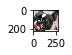

n02096585
[INFO] Predicted: 1, Actual: 1


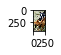

n02108089
[INFO] Predicted: 2, Actual: 2


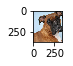

n02108089
[INFO] Predicted: 2, Actual: 2


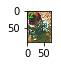

n02108089
[INFO] Predicted: 2, Actual: 2


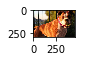

n02108089
[INFO] Predicted: 2, Actual: 2


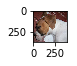

n02108089
[INFO] Predicted: 2, Actual: 2


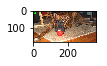

n02108089
[INFO] Predicted: 2, Actual: 2


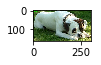

n02108089
[INFO] Predicted: 2, Actual: 2


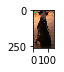

n02108089
[INFO] Predicted: 2, Actual: 2


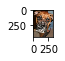

In [99]:
%matplotlib inline

# randomly select a few testing digits
for i in np.random.choice(np.arange(0, len(testLabels)), size=(10,)):
    # classify the digit
    probs = model.predict(testData[np.newaxis, i])
    prediction = probs.argmax(axis=1)
    
    path = 'data/test/'+testFolders[i]+'/'+testFiles[i]
    print(testFolders[i])
    try:
        image = io.imread(path+'.jpeg')
    except:
        image = io.imread(path+'.JPEG')
    
    
    label = imagePath.split(os.path.sep)[-1].split(".")[0]
    
    cv2.putText(image, str(prediction[0]), (5, 20),
        cv2.FONT_HERSHEY_SIMPLEX, 0.75, (0, 255, 0), 2)

    # show the image and prediction
    print("[INFO] Predicted: {}, Actual: {}".format(prediction[0],
        np.argmax(testLabels[i])))
    # create a grid of 3x3 images
    plt.subplot(530 + 1 + i)
    plt.imshow(image)
# show the plot
    plt.show()
# Boston: n02096585 = 1
# Beagle: n02088364 = 0
# Boxer:  n02108089 = 2